# Mobile-Device-Usage-Classification

# Imports

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline as sklearnPipeline
from sklearn.compose import ColumnTransformer


from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, make_scorer, confusion_matrix
from sklearn.metrics import roc_curve as sklearn_roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_predict, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

# Functions

In [47]:
def check_nulls_dupes(df):
  print(f"The amount of nulls: {df.isna().sum()}")
  print(f"The amount of Dupes: {df.duplicated().sum()}")

def check_class_imbalance(target):
  unique, counts = np.unique(target, return_counts=True)
  
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.title("Target Class Breakdown")
  plt.legend()
  plt.show()
  
  plt.figure(figsize=(10, 7))
  sns.countplot(x=target)
  plt.xlabel("Target Class Breakdown")
  plt.ylabel("Counts")
  plt.show()

def plot_distribution(df, kind):
  
  plt.figure(figsize=(16,16))
  rows = len(df.columns)
  dims = (rows+ 3)//4
  for idx, col in enumerate(df.columns):
    plt.subplot(dims, 4, idx+1)
    sns.histplot(df[col], kde=True) if kind == "Hist" else plt.boxplot(df[col])
    plt.title(f"Distribuition of {col}")
    plt.ylabel("Counts")
  plt.tight_layout()
  plt.show()

def aggregate_dataset(df, interested_columns, agg_col, function):
  
  plt.figure(figsize=(16, 16))
  rows = len(interested_columns)
  dims = (rows + 3 )//4
  
  for idx, col in enumerate(interested_columns):
    grouped_df = getattr(df.groupby(agg_col)[col], function)().reset_index(name=col)
    plt.subplot(dims, 4, idx+1)
    sns.barplot(data=grouped_df, x=agg_col, y=col)
    plt.title(f"Agg of {col}")
    plt.ylabel(col)
    plt.xticks(rotation =45)
  
  plt.tight_layout()
  plt.show()

def plot_confusion_matrix(y_true, y_pred, model_name):
  
  plt.figure(figsize=(10, 7))
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(data=cm, annot=True, fmt="d", cmap="Blues")
  plt.title(f"Confusion Matrix For: {model_name}")
  plt.ylabel("Predicted Labels")
  plt.xlabel("True Labels")
  plt.show()

def plot_roc_curve(X,y, sample_model, model, kbest):
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42,stratify=y)
  pipeline = create_pipeline(sample_model, model, kbest)
  
  pipeline.fit(X_train, y_train)
  y_scores = pipeline.predict_proba(X_test)[:, 1]
  
  fpr, tpr, thresholds = sklearn_roc_curve(y_test, y_scores)
  roc_auc = auc(fpr, tpr)
  print(f"The AUC is: {roc_auc:.2f}")

  plt.figure()
  lw = 2
  plt.plot(fpr, tpr, color='darkorange', lw=lw, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic')
  plt.legend(loc="lower right")
  plt.show()

def create_column_transformer(cat_cols, numeric_cols):
  
  cat_transformer = sklearnPipeline(
    steps=[
      ("encoder", OneHotEncoder())
    ]
  )
  
  numeric_transformer = sklearnPipeline(
    steps =[
      ("scaler", StandardScaler()),
      ("PowerTransformer", PowerTransformer())
    ]
  )
  
  return ColumnTransformer(
    transformers=[
      ("cat", cat_transformer, cat_cols),
      ("numeric", numeric_transformer, numeric_cols)
    ]
  )

def create_pipeline(preprocessor, model, kbest=None):
  
  steps = [
    (preprocessor, "preprocessor")
    ("model", model)
  ]
  
  if kbest:
    steps.insert(1, ("Feature-Selector", kbest))
  
  return sklearnPipeline(steps=steps)

def create_sklearn_pipeline(preprocessor, model):
  
  steps = [
    (preprocessor, "preprocessor"),
    ("model", model)
  ]
  
  return sklearnPipeline(steps=steps)

def grab_selected_models(names):
  
  models = {
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier(),
    "DUMMY": DummyClassifier(strategy="stratified")
  }
  
  return [models[model_name] for model_name in names]

def get_metrics(y, predictions):
    acc_metric = accuracy_score(y, predictions)
    recall_metric = recall_score(y, predictions, average='weighted')
    precision_metric = precision_score(y, predictions, average='weighted')
    f1_metric = f1_score(y, predictions, average='weighted')
    
    return [acc_metric,recall_metric, precision_metric, f1_metric]

def evaluate_model(model, X, y, metric):
  
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10,random_state=1)
  scores = cross_val_score(model, X, y, cv=cv, scoring=metric, n_jobs=-1)
  preds = cross_val_predict(model, X, y, n_jobs=-1, cv=10)
  acc, recall_metric, precision_metric, f1_metric = get_metrics(y, preds)
  
  return [
    round(np.mean(scores),3), 
    round(np.var(scores), 3), 
    round(np.std(scores),3), 
    round(acc,3), 
    round(recall_metric,3),
    round(precision_metric,3),
    round(f1_metric,3)
  ]

def test_selected_models(preprocessor, model_names, models, X, y, scoring_metric, kbest=None):
  
  metric_tracker = []
  
  for model, model_name in zip(models, model_names):
    pipeline = create_pipeline(preprocessor,model, kbest) if kbest else create_pipeline(preprocessor,model) 
    scores = evaluate_model(pipeline, X, y, scoring_metric)
    
    metric_tracker.append({
      "Model": model_name,
      "Mean": scores[0],
      "Var": scores[1],
      "STD": scores[2],
      "Test-Acc":scores[3],
      "recall-Score":scores[4],
      "precision-Score":scores[5],
      "F1-Score":scores[6]
    })
  
  performance_df = pd.DataFrame(metric_tracker).sort_values(by="Mean", ascending=False)
  print(performance_df)

def test_kbest_columns(preprocessor, X, y, model, model_name, kbest):
  
  metric_tracker = []
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
  for k in range(1, X.shape[1]+1):
    metric = SelectKBest(score_func=kbest, k=k)
    pipeline = create_pipeline(preprocessor, model, metric)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    acc, recall_metric, precision_metric, f1_metric = get_metrics(y_test, y_pred)

    metric_tracker.append({
        "Model": model_name,
        "K":k,
        "acc_metric": acc,
        "f1_metric": f1_metric,
        "recall":recall_metric,
        "precision":precision_metric
      })
  
  return pd.DataFrame(metric_tracker)

def pca_analysis(X, preprocessor):
  
  features = range(1, X.shape[1]+1)
  metric_tracker = []
  
  for n in features:
    pca = PCA(n_components=n)
    pipeline = create_sklearn_pipeline(preprocessor, pca)
    X_pca = pipeline.fit_transform(X)
    
    cumsum = np.sum(pca.explained_variance_ratio_)
    
    metric_tracker.append({
      "Component":n,
      "CumSum":cumsum
    }
    )
    
  performance_df = pd.DataFrame(metric_tracker)
  plt.figure(figsize=(12, 8))
  plt.title("PCA Analysis")
  sns.barplot(data=performance_df, x="Component", y="CumSum")
  plt.xlabel("Components")
  plt.ylabel("CumSum")
  plt.show()
  print(performance_df)

def optimization_search(preprocessor, model_names, models,X, y, optimizer_class, param_distributions, scoring_metric, kbest):
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
  metric_tracker = []
  
  for model_name, model in zip(model_names, models):
    model_pipeline = create_pipeline(preprocessor, model, kbest)
    current_params = param_distributions.get(model_name, {})
    opt_search= optimizer_class(model_pipeline, param_distributions=current_params, cv=10, scoring=scoring_metric, n_jobs=-1)
    opt_search.fit(X_train, y_train)
    
    best_model = opt_search.best_estimator_
    best_params = opt_search.best_params_
    y_pred = best_model.predict(X_test)
    
    acc, recall_metric, precision_metric, f1_metric = get_metrics(y_test, y_pred)
      
    plot_confusion_matrix(y_test, y_pred, model_name)
    print(f"The Best Param: {best_params}")
    metric_tracker.append({
        "Model": model_name,
        "Test-Acc":acc,
        "F1-Score":f1_metric,
        "recall-Score":recall_metric,
        "precision-Score":precision_metric,
      })
  
  return pd.DataFrame(metric_tracker)

def test_voting_classifier(preprocessor, X,y, model,kbest, model_name):
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
  metric_tracker = []
  model_pipeline = create_pipeline(preprocessor, model, kbest)
  model_pipeline.fit(X_train, y_train)
  y_pred = model_pipeline.predict(X_test)
    
  acc, recall_metric, precision_metric, f1_metric = get_metrics(y_test, y_pred)
      
  plot_confusion_matrix(y_test, y_pred, model_name)
  metric_tracker.append({
        "Model": model_name,
        "Test-Acc":acc,
        "F1-Score":f1_metric,
        "recall-Score":recall_metric,
        "precision-Score":precision_metric,
      })
  
  return pd.DataFrame(metric_tracker)

<>:109: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
<>:109: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
/var/folders/bb/2qsf8cm95jg05zrms2_8m2qr0000gn/T/ipykernel_33055/2451622003.py:109: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
  (preprocessor, "preprocessor")


# EDA Analysis

In [2]:
df = pd.read_csv("/Users/maukanmir/Downloads/user_behavior_dataset.csv")
df

,User ID,Device Model,Operating System,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age,Gender,User Behavior Class
0,1,Google Pixel 5,Android,393,6.4,1872,67,1122,40,Male,4
1,2,OnePlus 9,Android,268,4.7,1331,42,944,47,Female,3
2,3,Xiaomi Mi 11,Android,154,4.0,761,32,322,42,Male,2
3,4,Google Pixel 5,Android,239,4.8,1676,56,871,20,Male,3
4,5,iPhone 12,iOS,187,4.3,1367,58,988,31,Female,3
...,...,...,...,...,...,...,...,...,...,...,...
695,696,iPhone 12,iOS,92,3.9,1082,26,381,22,Male,2
696,697,Xiaomi Mi 11,Android,316,6.8,1965,68,1201,59,Male,4
697,698,Google Pixel 5,Android,99,3.1,942,22,457,50,Female,2
698,699,Samsung Galaxy S21,Android,62,1.7,431,13,224,44,Male,1


In [3]:
df.dtypes

User ID                         int64
Device Model                   object
Operating System               object
App Usage Time (min/day)        int64
Screen On Time (hours/day)    float64
Battery Drain (mAh/day)         int64
Number of Apps Installed        int64
Data Usage (MB/day)             int64
Age                             int64
Gender                         object
User Behavior Class             int64
dtype: object

In [4]:
df.describe()

,User ID,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age,User Behavior Class
count,700.00000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000
mean,350.50000,271.128571,5.272714,1525.158571,50.681429,929.742857,38.482857,2.990000
std,202.21688,177.199484,3.068584,819.136414,26.943324,640.451729,12.012916,1.401476
min,1.00000,30.000000,1.000000,302.000000,10.000000,102.000000,18.000000,1.000000
25%,175.75000,113.250000,2.500000,722.250000,26.000000,373.000000,28.000000,2.000000
50%,350.50000,227.500000,4.900000,1502.500000,49.000000,823.500000,38.000000,3.000000
75%,525.25000,434.250000,7.400000,2229.500000,74.000000,1341.000000,49.000000,4.000000
max,700.00000,598.000000,12.000000,2993.000000,99.000000,2497.000000,59.000000,5.000000


# Check Class Imbalance

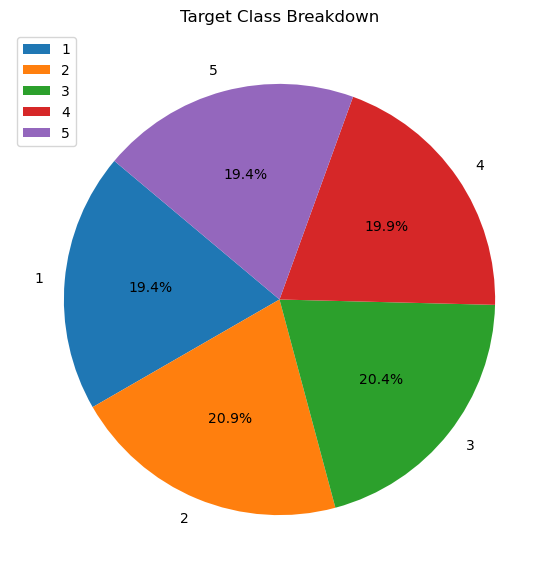

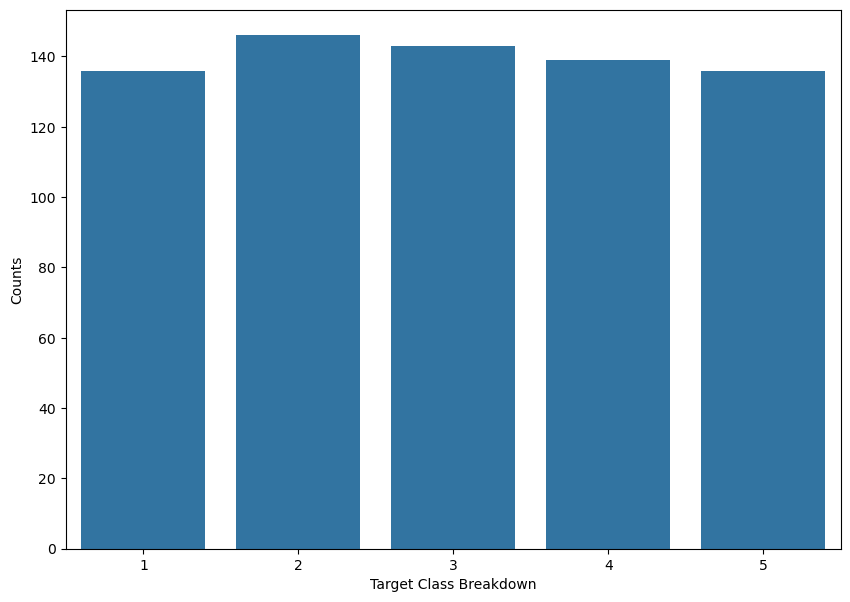

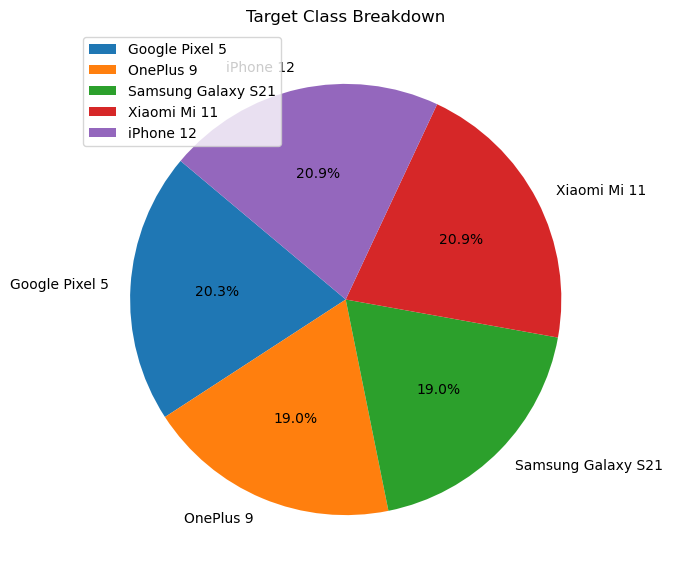

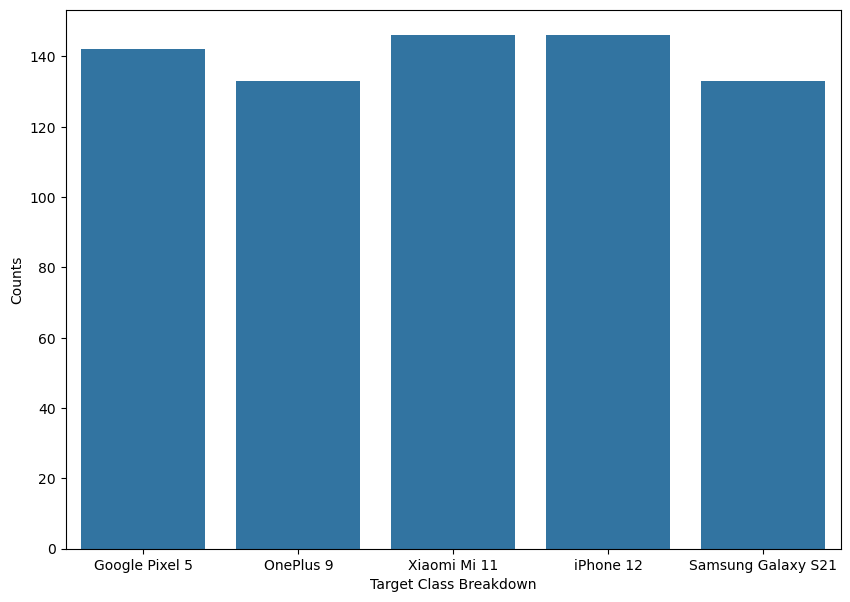

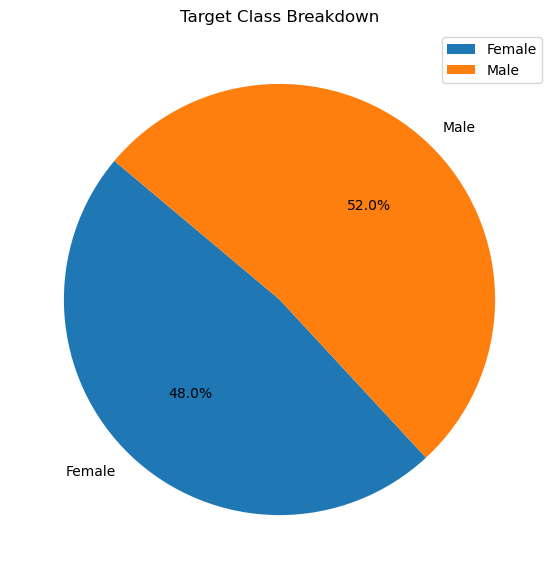

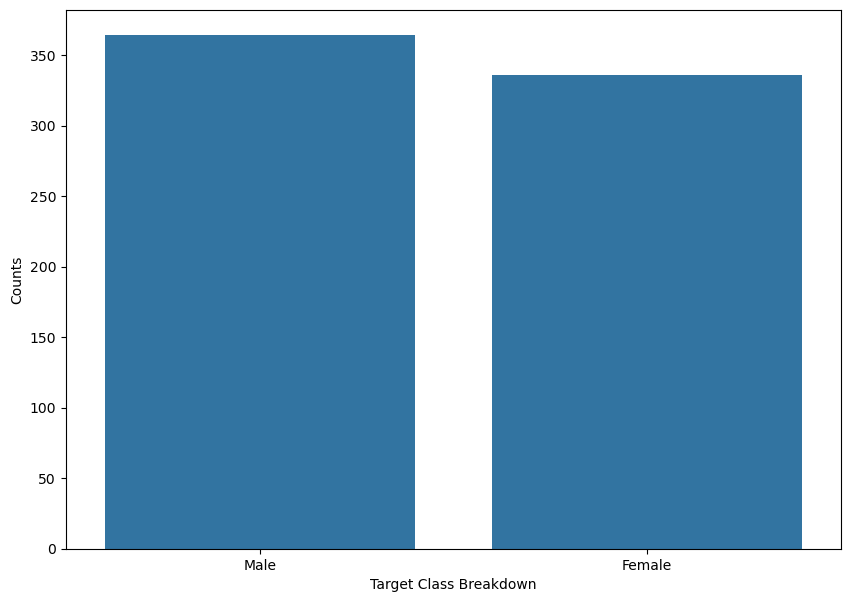

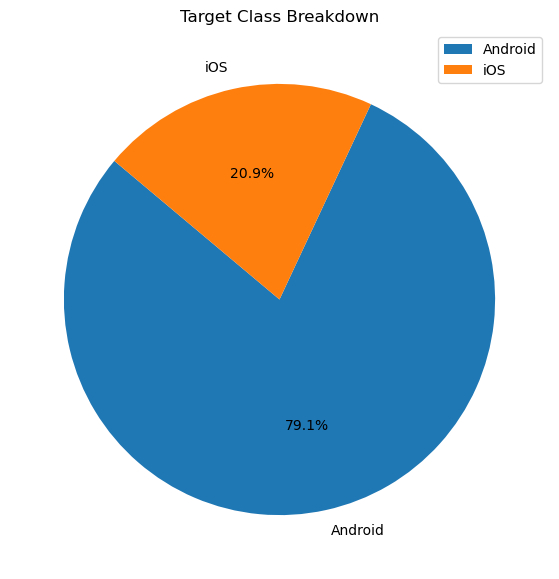

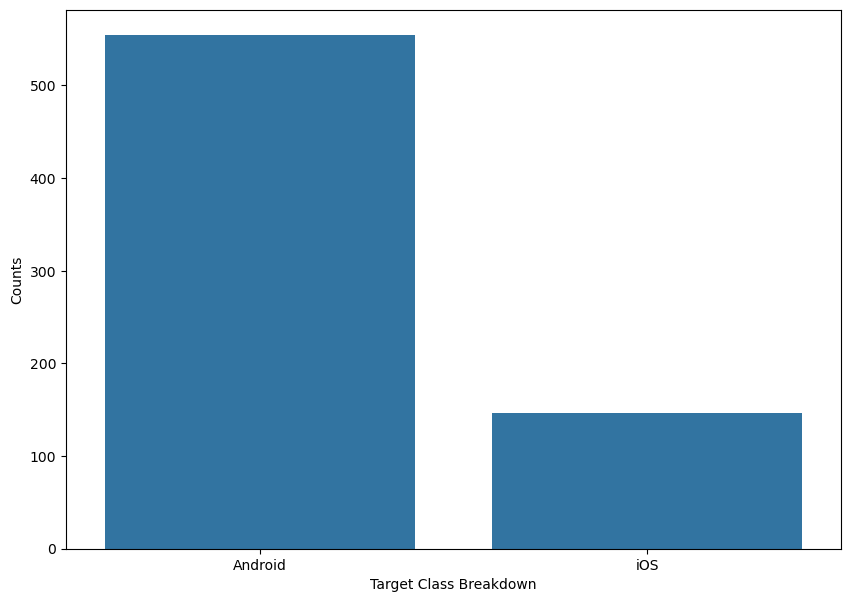

In [9]:
check_class_imbalance(df["User Behavior Class"])
check_class_imbalance(df["Device Model"])
check_class_imbalance(df["Gender"])
check_class_imbalance(df["Operating System"])

In [14]:
df.drop("User ID", axis=1, inplace=True)

# Split Dtypes

In [18]:
numerical_types = df.select_dtypes(include=["int64", "float64"])
categorical_types = df.select_dtypes(include="object")

# Visuals

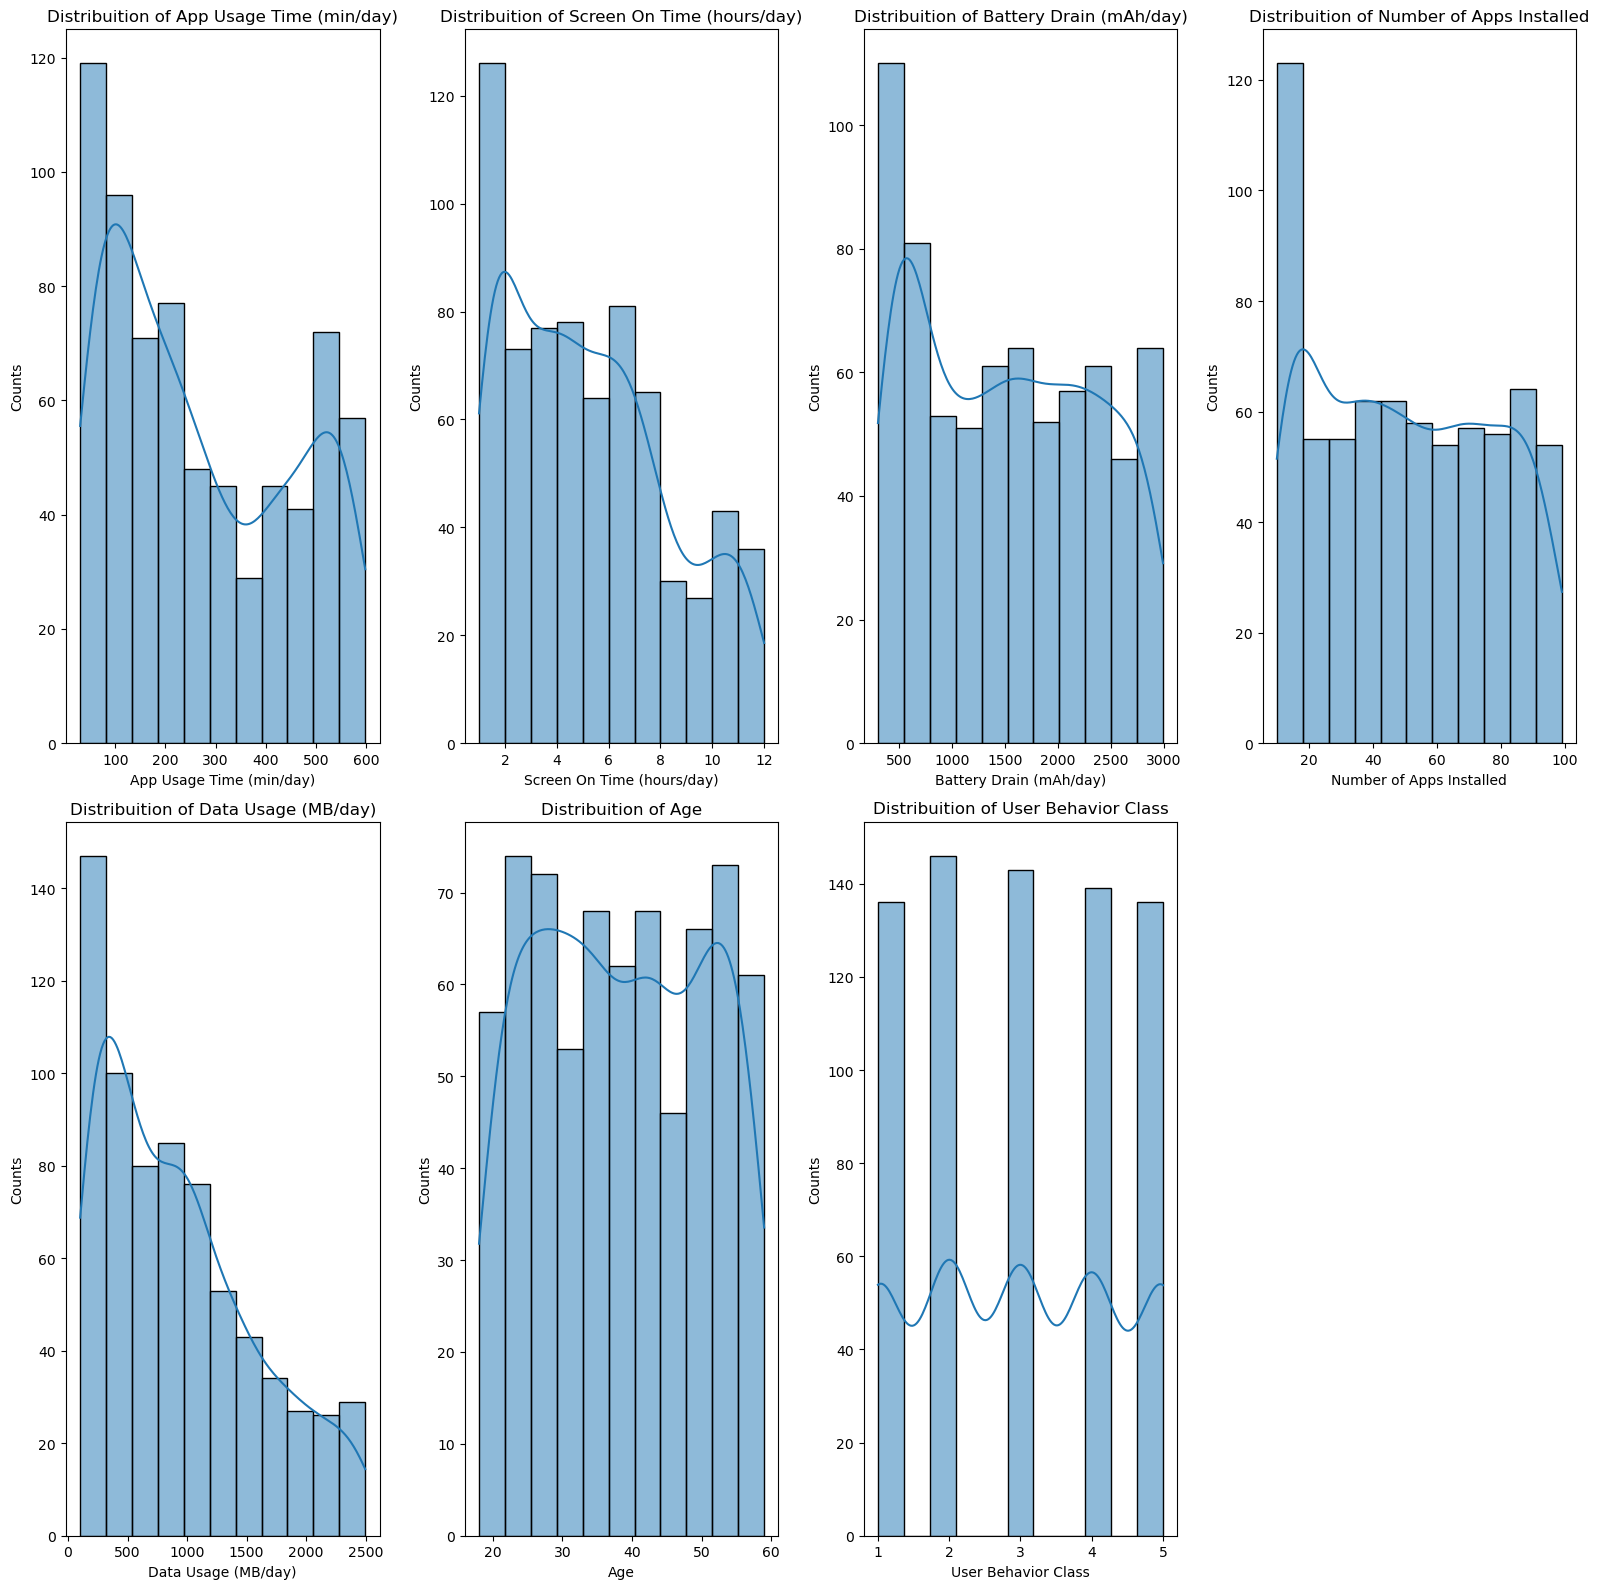

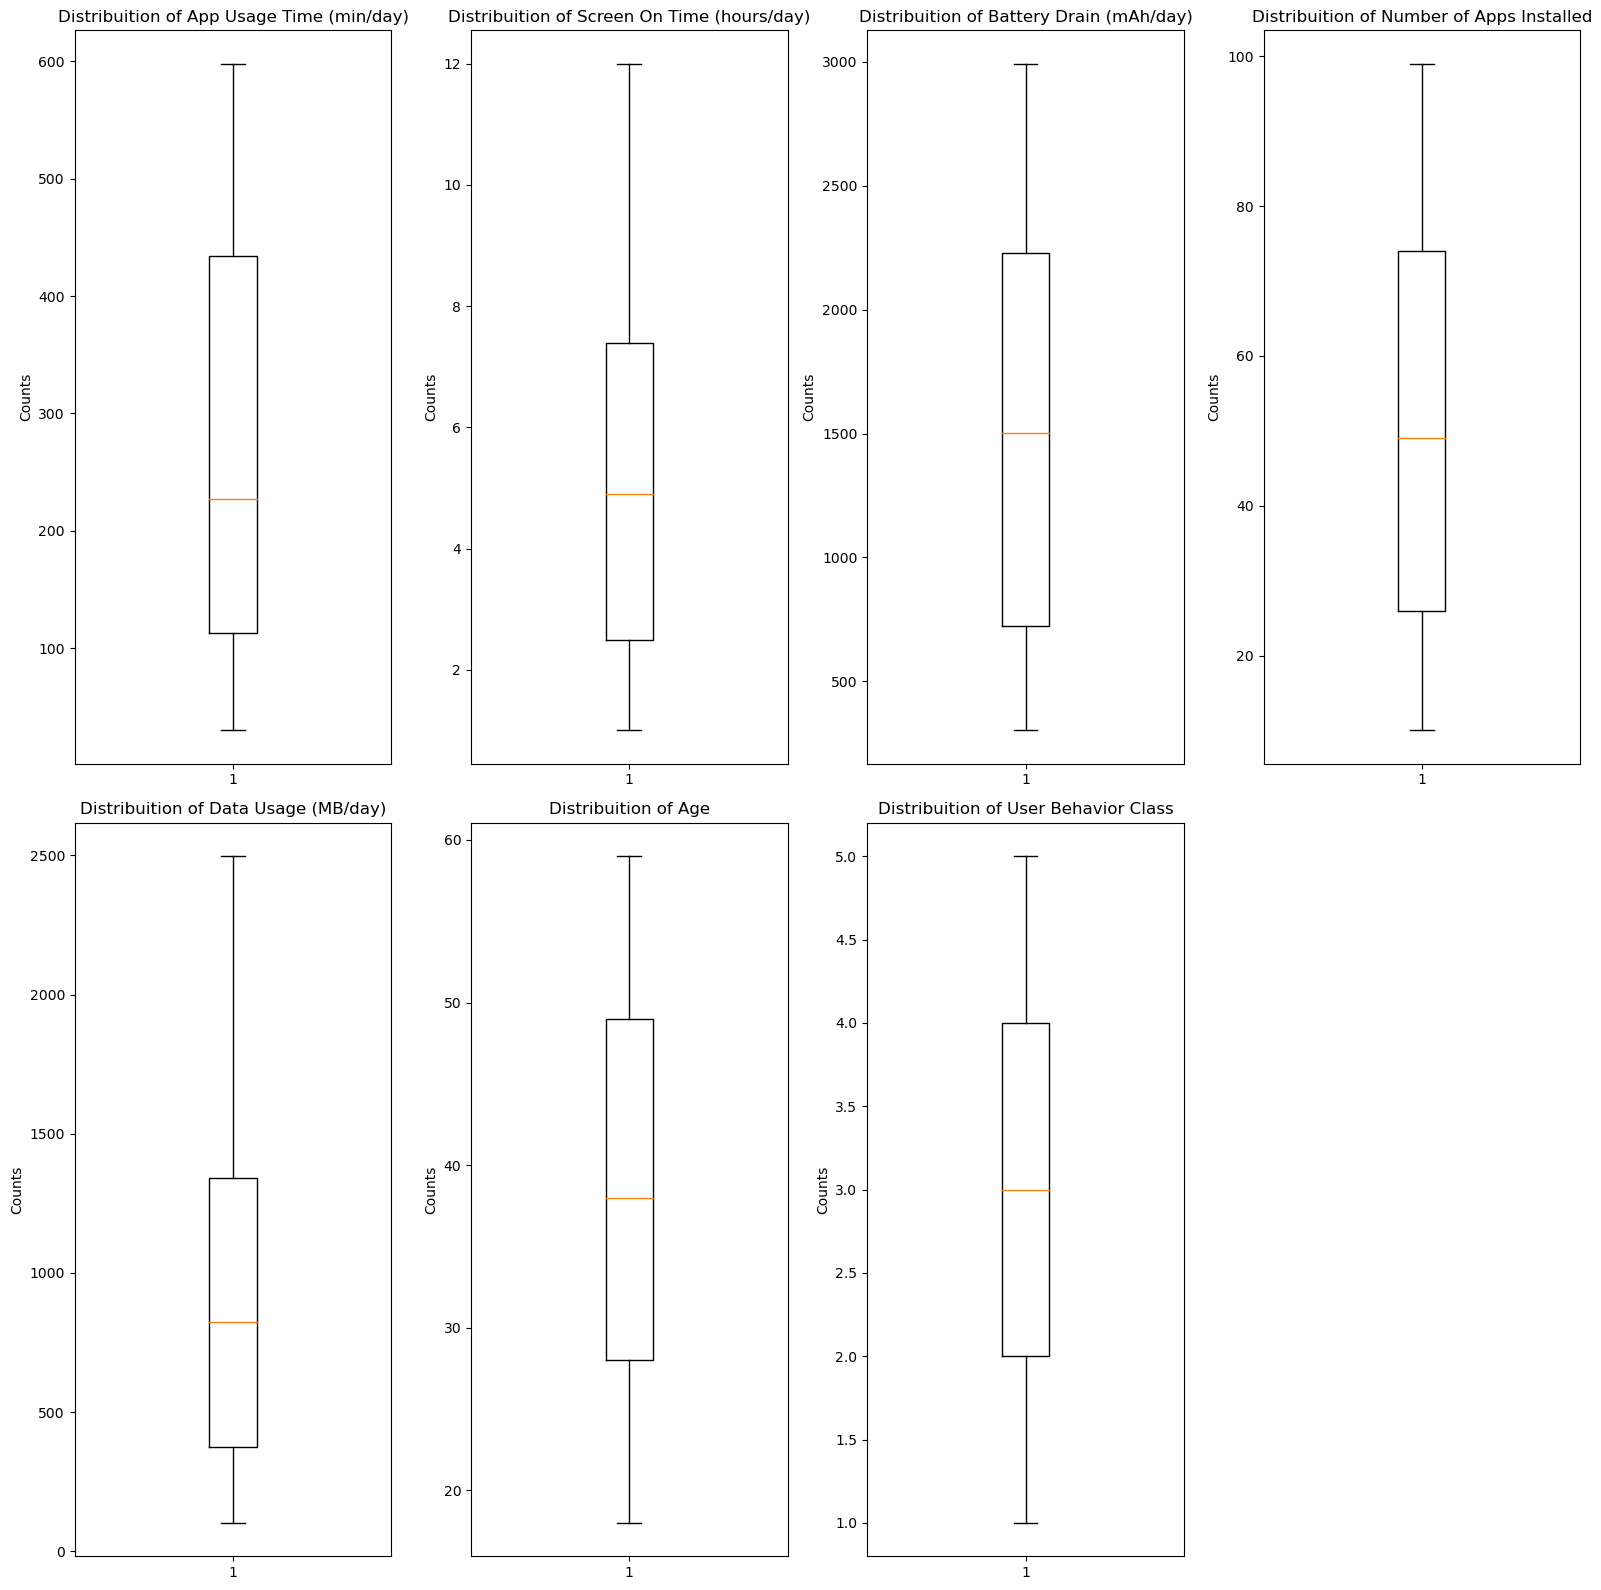

In [20]:
plot_distribution(numerical_types, "Hist")
plot_distribution(numerical_types, "box")

# Heatmap

<AxesSubplot:>

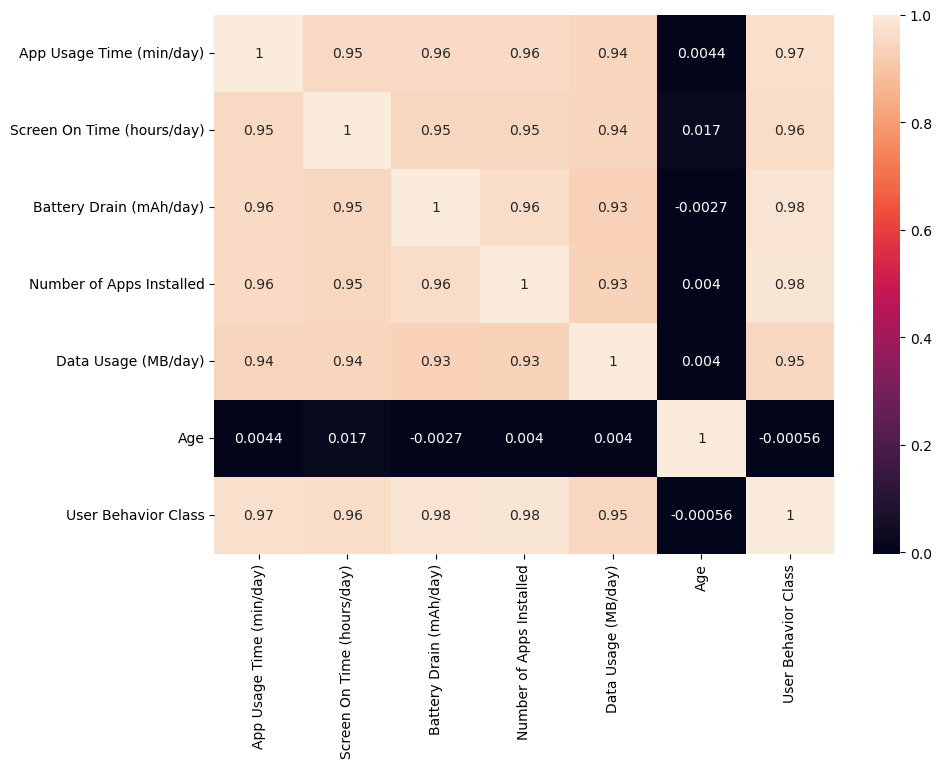

In [21]:
plt.figure(figsize=(10, 7))
relations = numerical_types.corr()
sns.heatmap(data=relations, annot=True)

# Aggregate Dateset

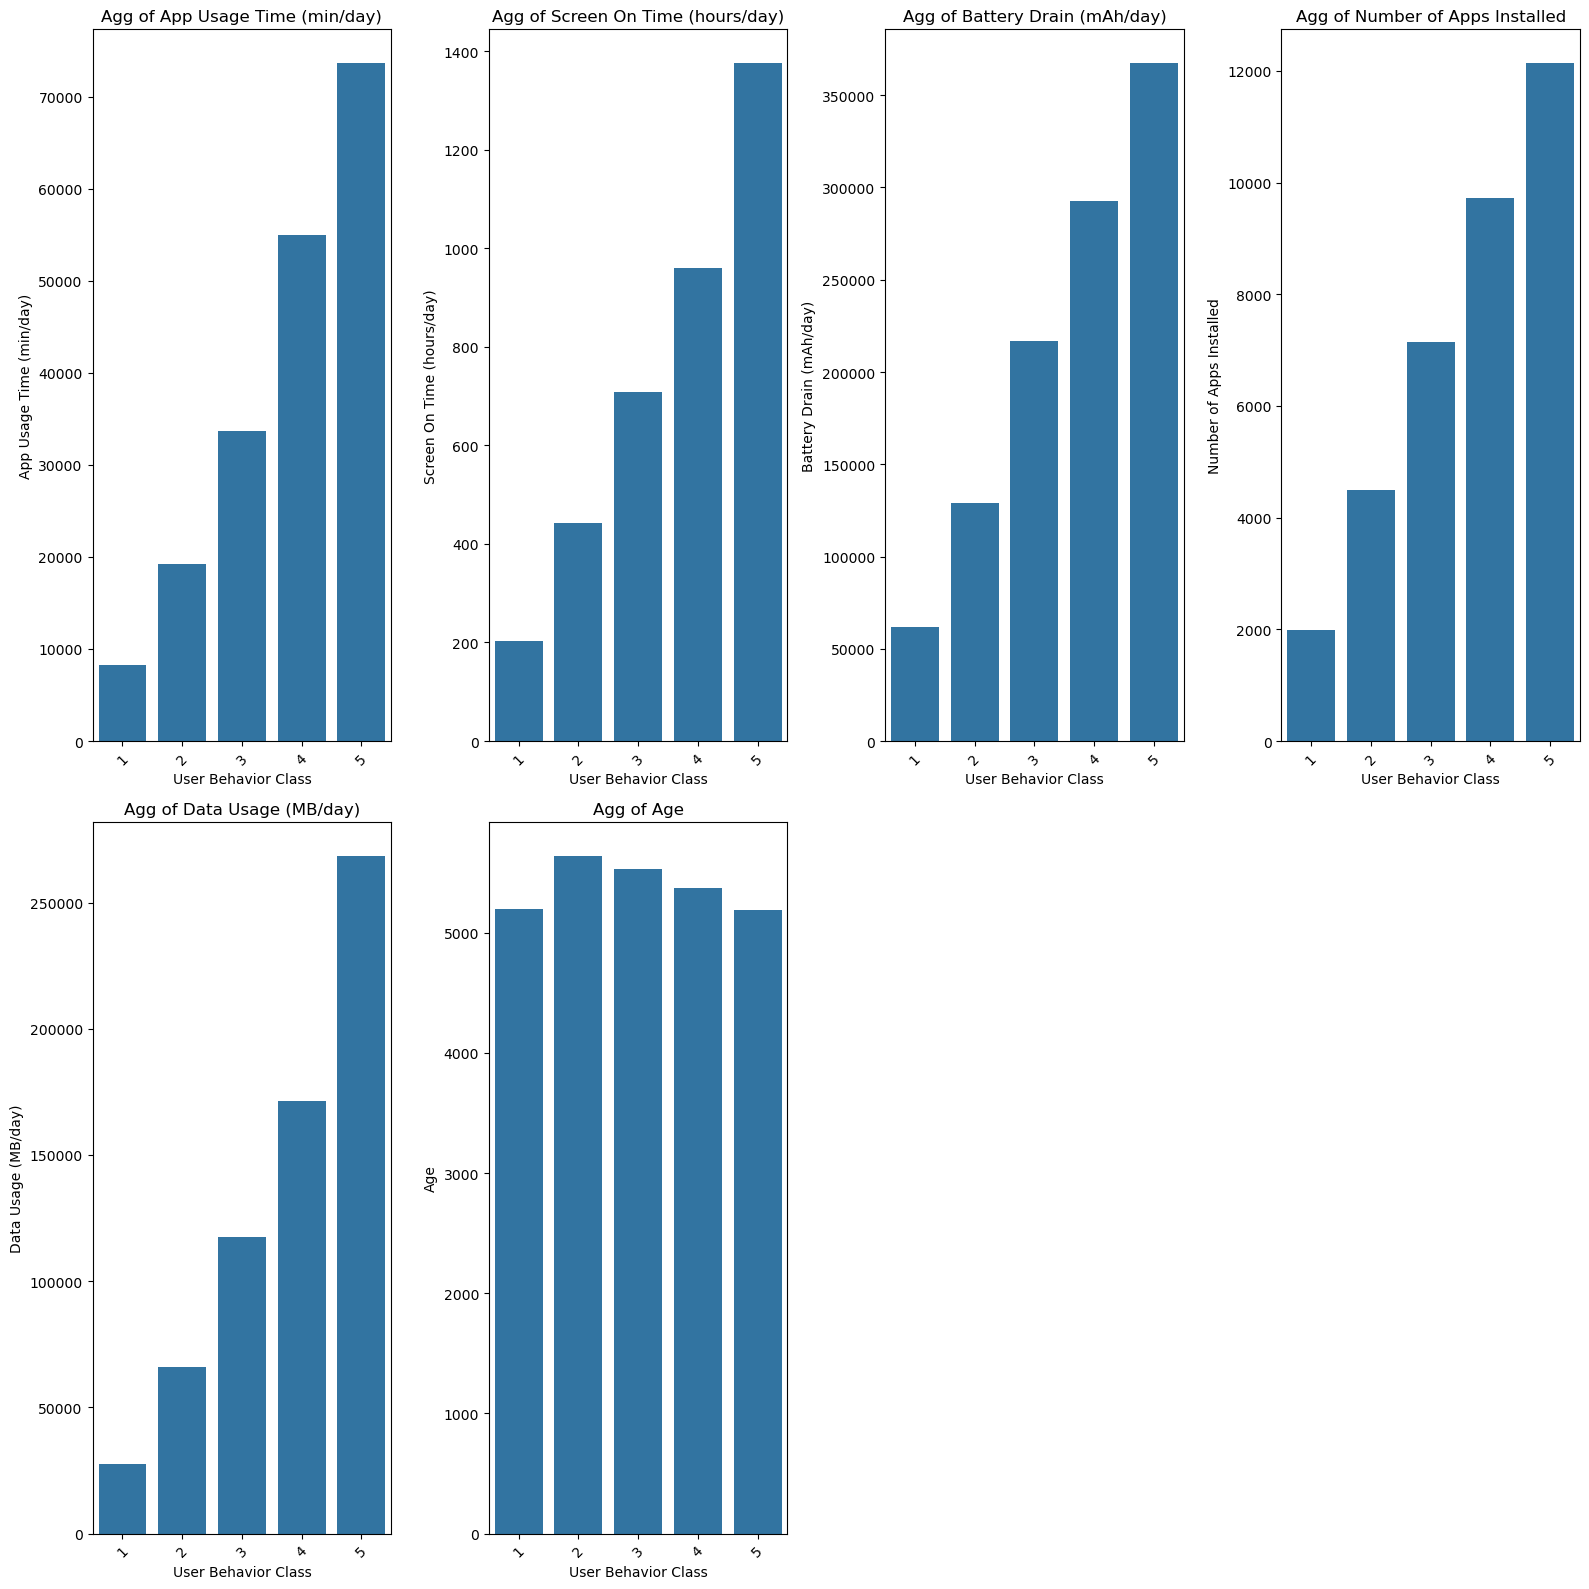

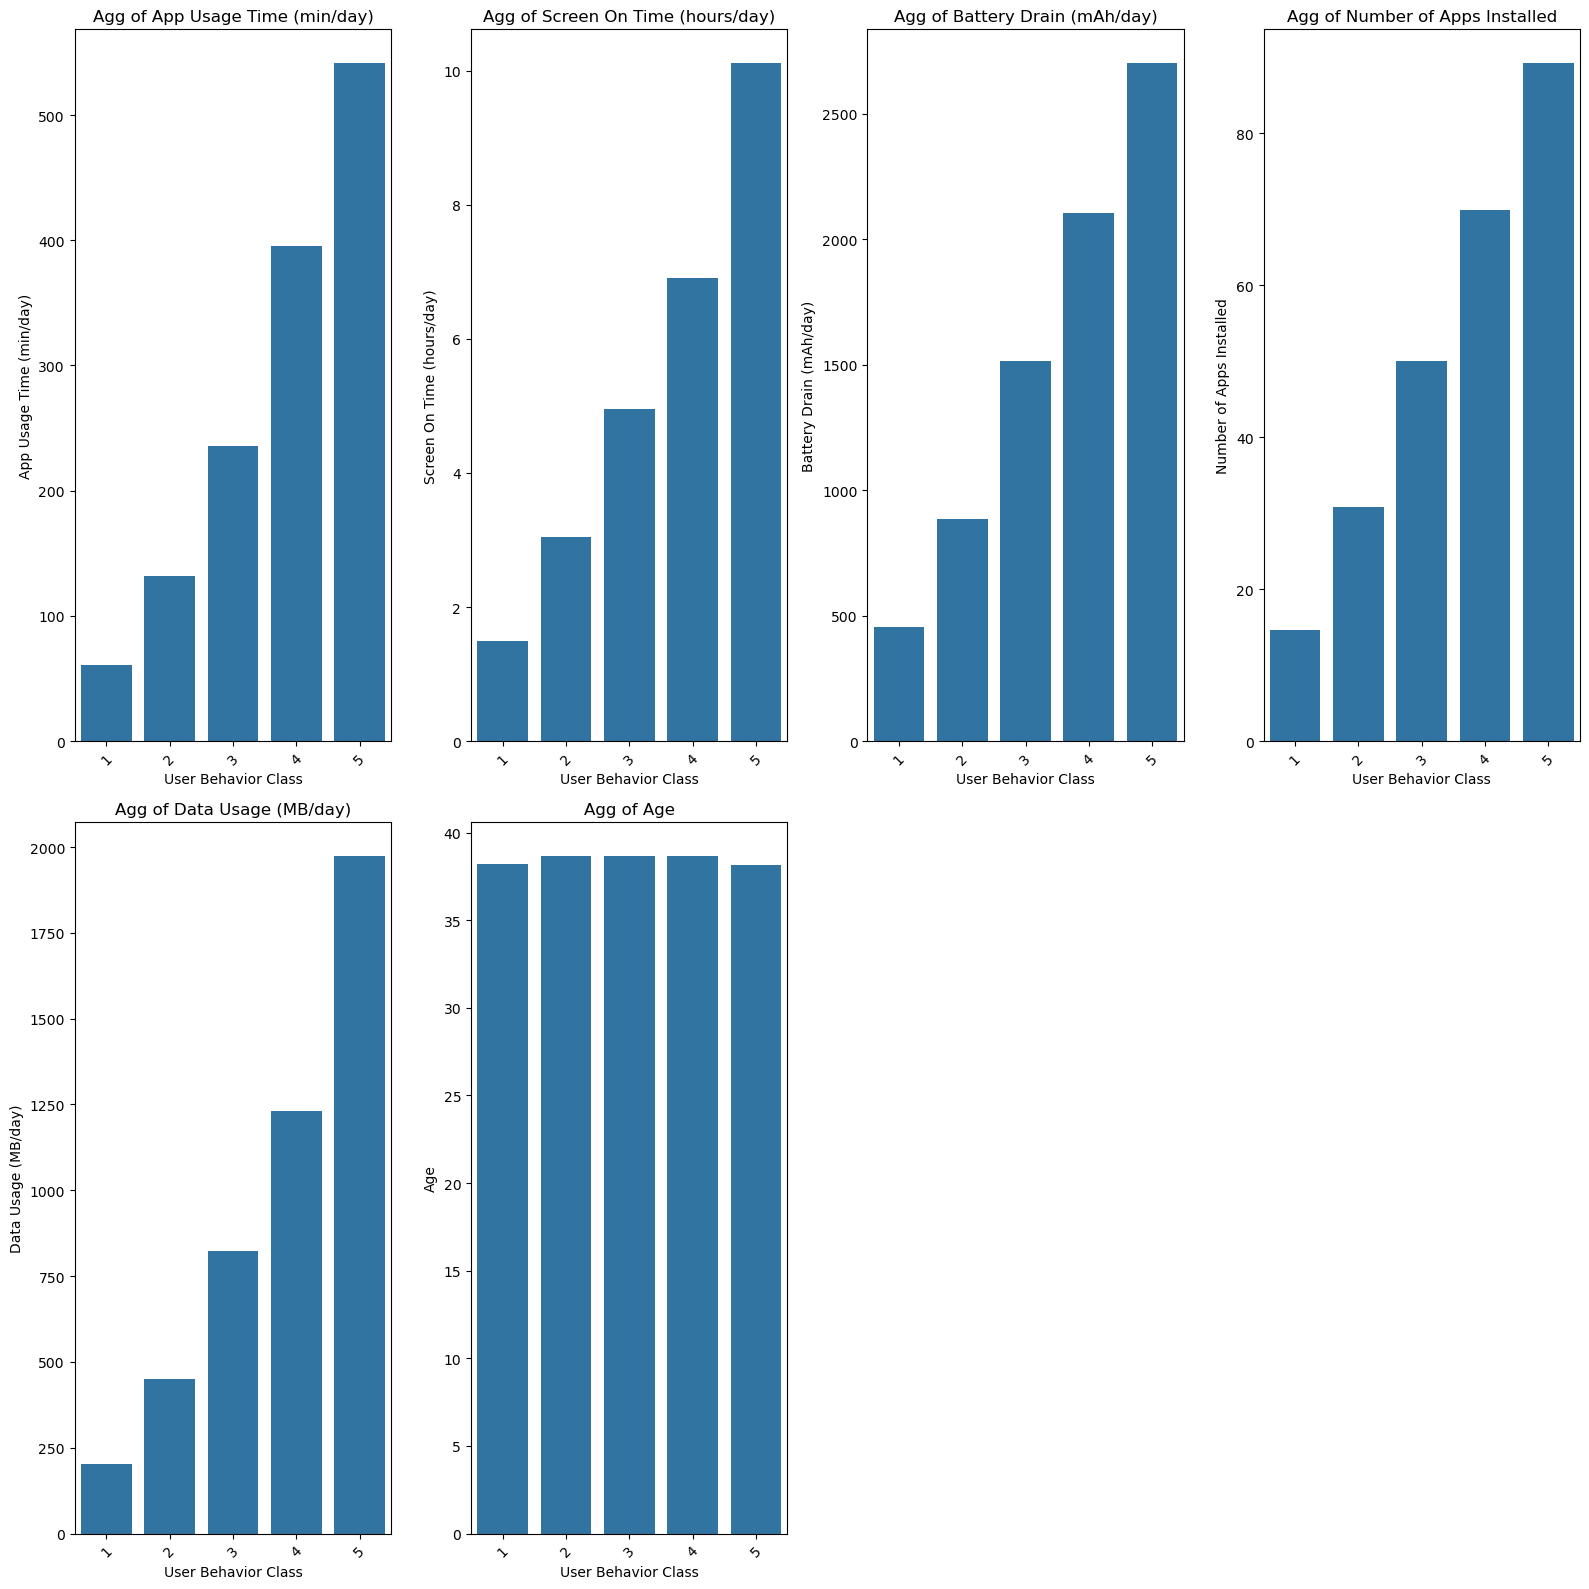

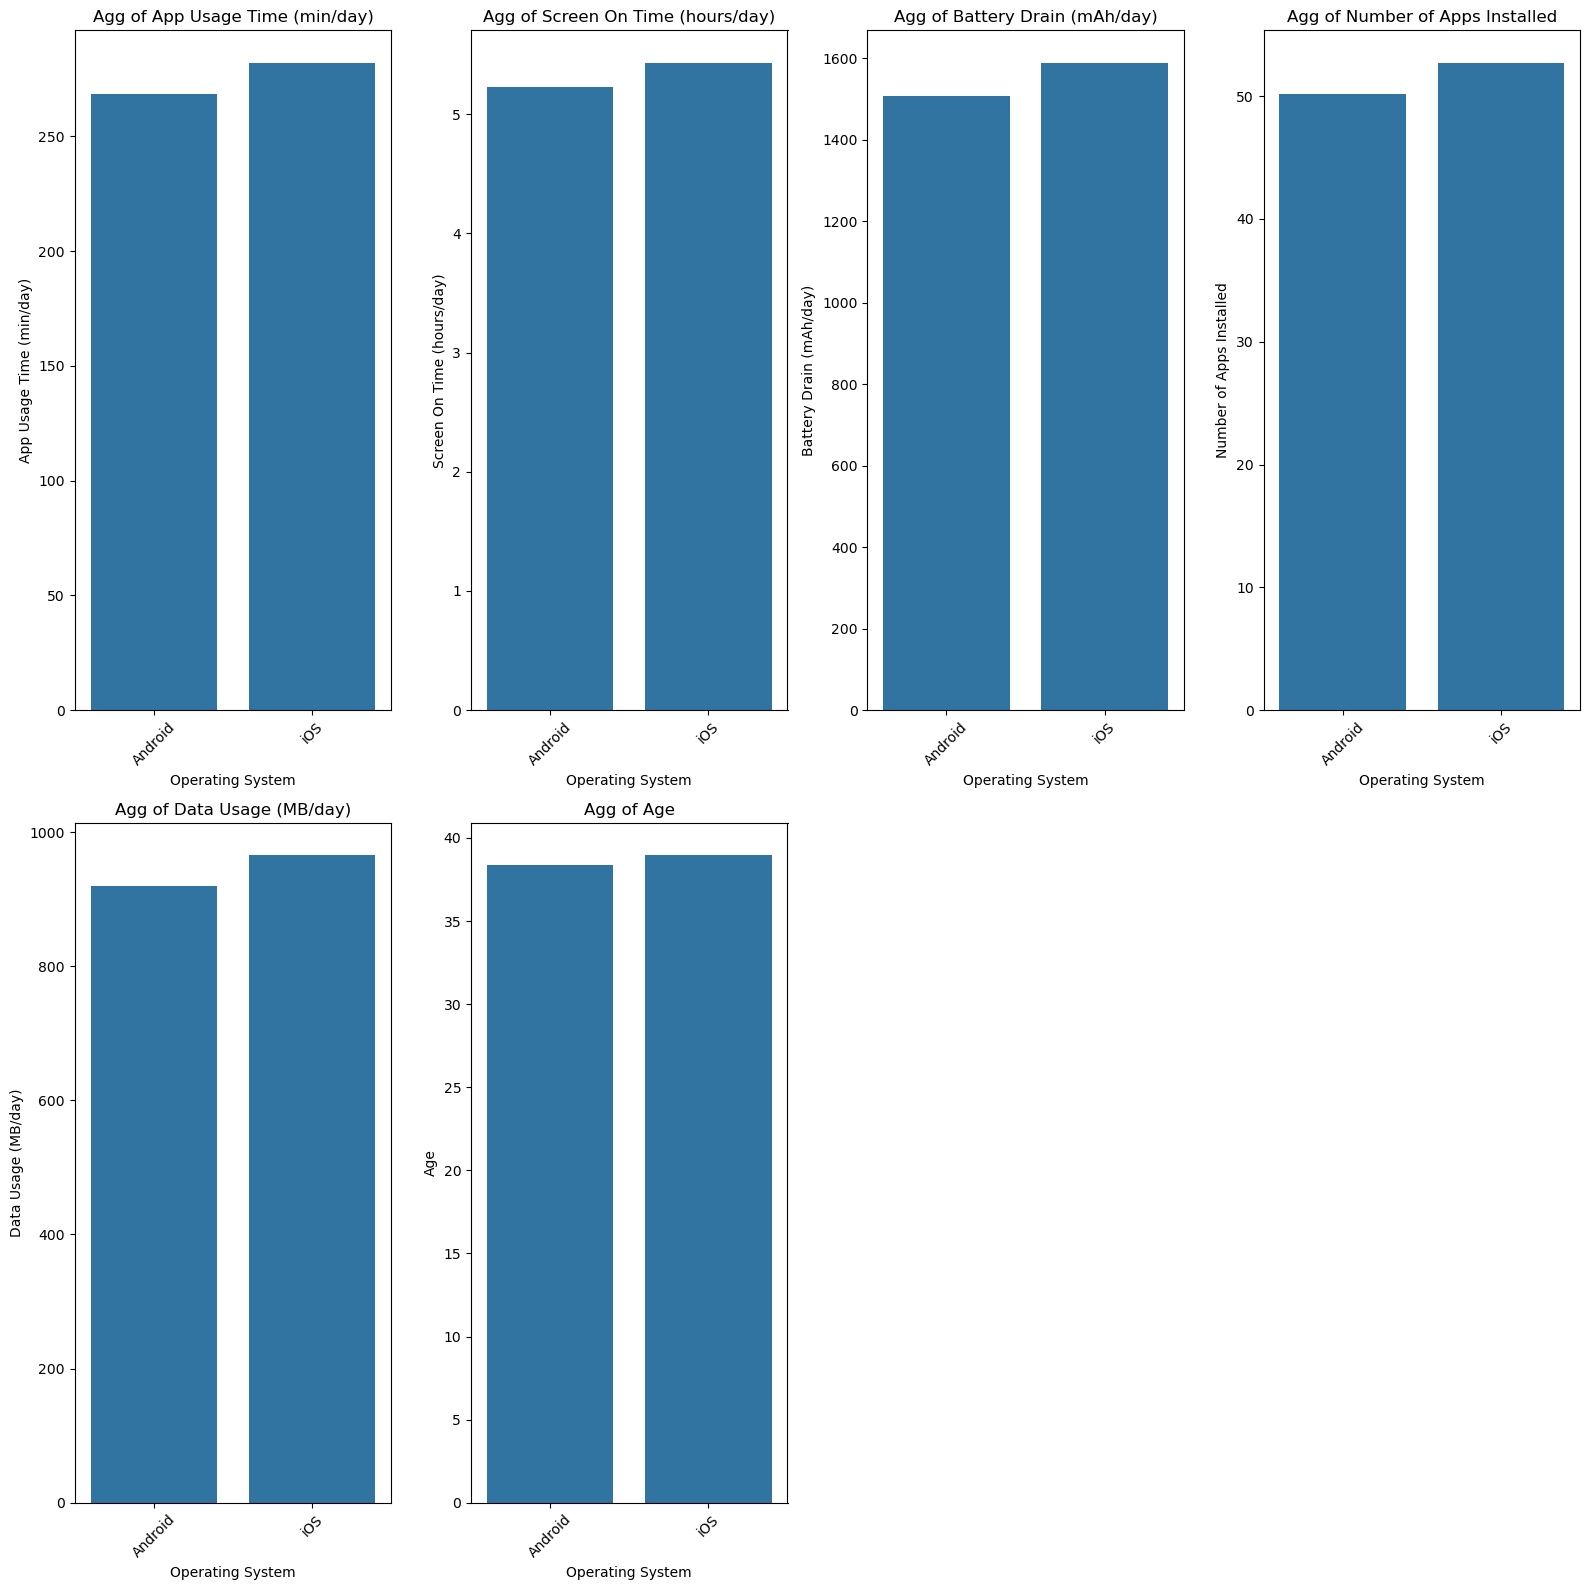

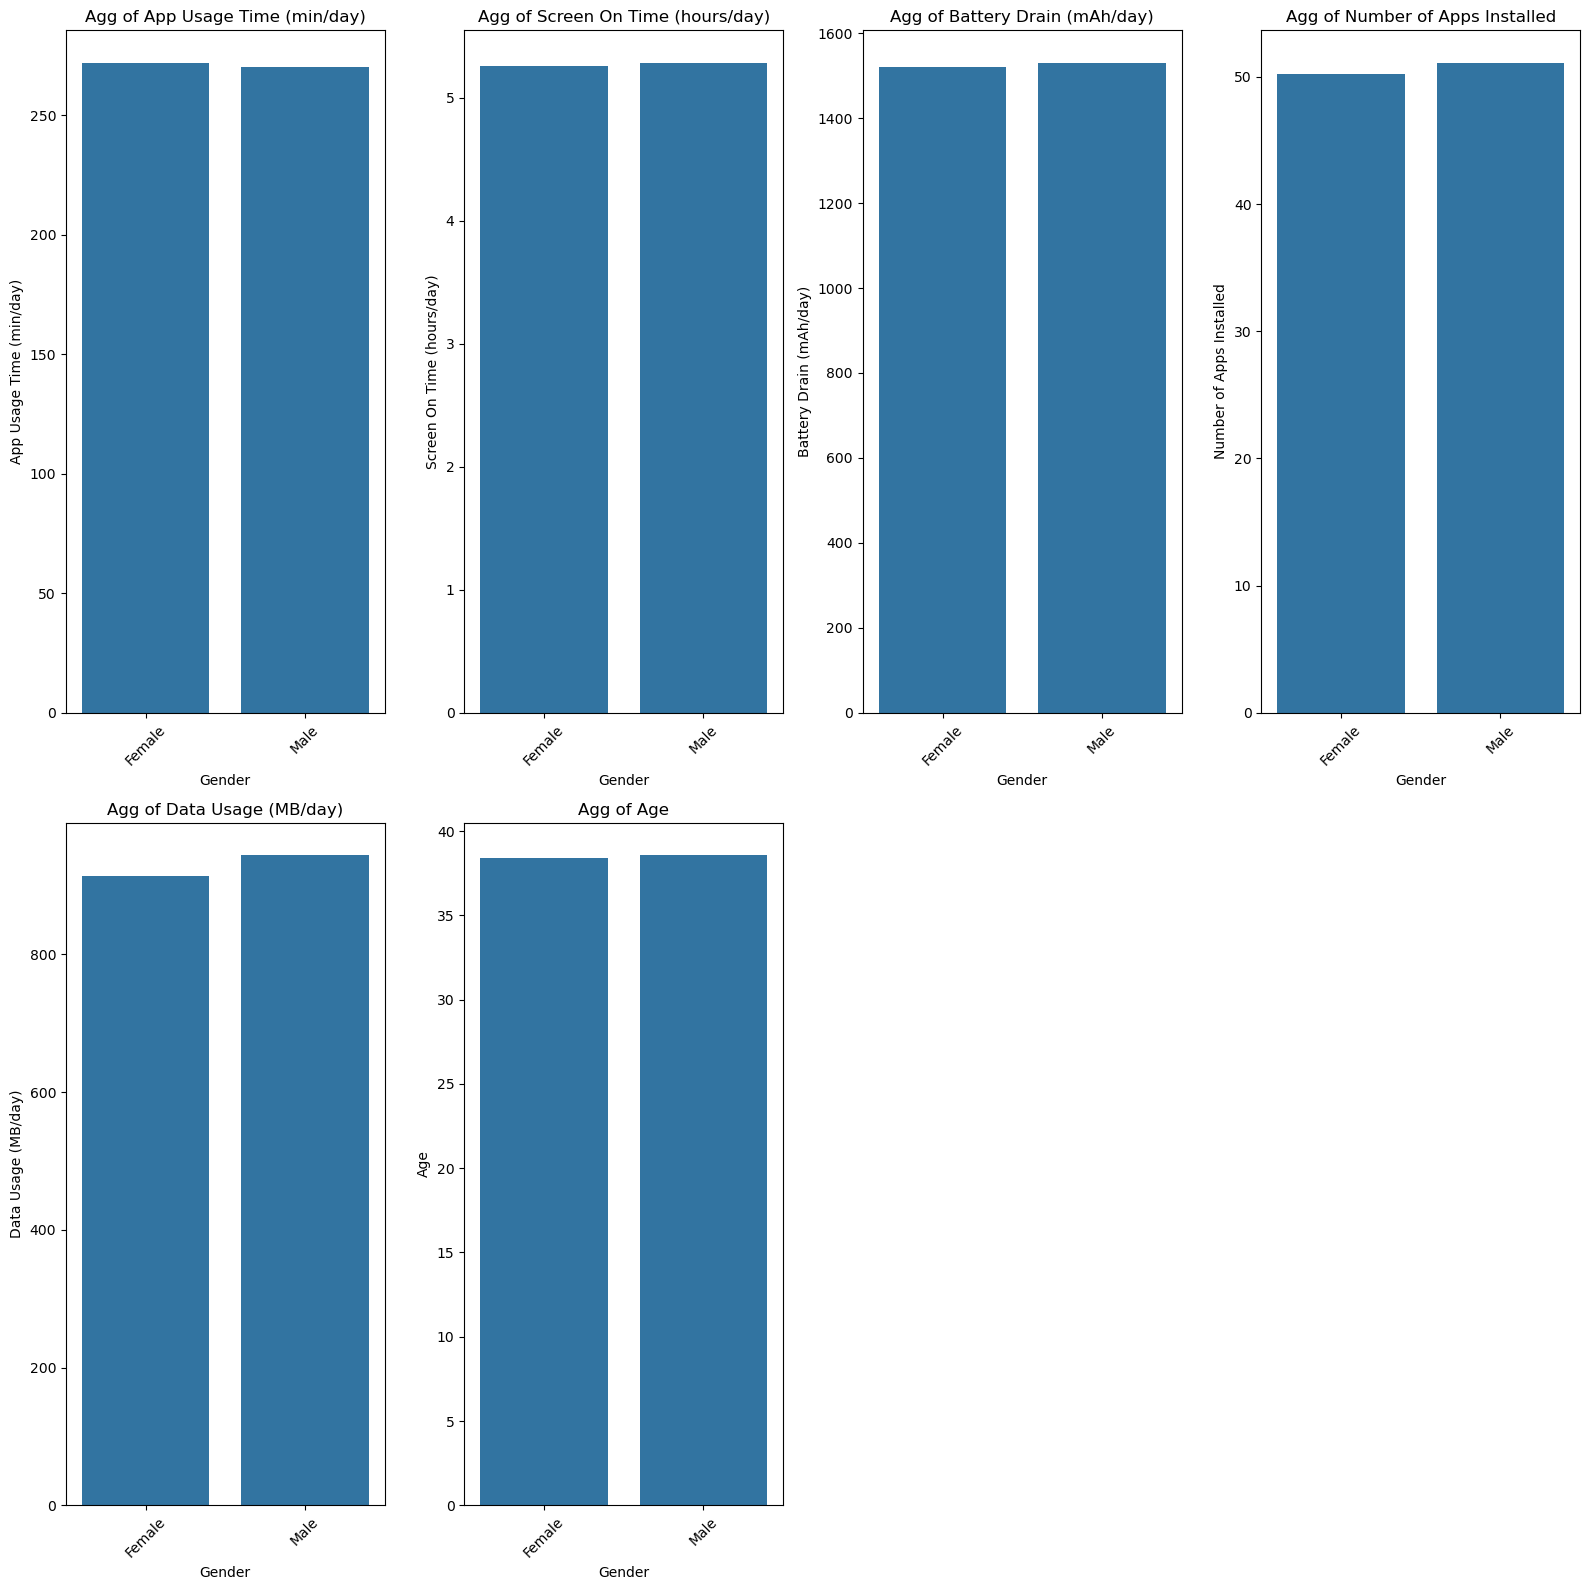

In [30]:
interested_columns = [col for col in numerical_types.columns if col != "User Behavior Class"]
aggregate_dataset(df, interested_columns, "User Behavior Class", "sum")
aggregate_dataset(df, interested_columns, "User Behavior Class", "mean")
aggregate_dataset(df, interested_columns, "Operating System", "mean")
aggregate_dataset(df, interested_columns, "Gender", "mean")

# Preprocessor

In [43]:
preprocessor = create_column_transformer(categorical_types.columns, interested_columns)
preprocessor

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('encoder', OneHotEncoder())]),
                                 Index(['Device Model', 'Operating System', 'Gender'], dtype='object')),
                                ('numeric',
                                 Pipeline(steps=[('scaler', StandardScaler()),
                                                 ('PowerTransformer',
                                                  PowerTransformer())]),
                                 ['App Usage Time (min/day)',
                                  'Screen On Time (hours/day)',
                                  'Battery Drain (mAh/day)',
                                  'Number of Apps Installed',
                                  'Data Usage (MB/day)', 'Age'])])

# Separate Variables

In [44]:
X = df.drop("User Behavior Class", axis=1)
y = df["User Behavior Class"]

# Create Metrics

In [45]:
acc_metric = make_scorer(accuracy_score, greater_is_better=True)
f1_metric = make_scorer(f1_score, greater_is_better=True, average="weighted")
precision_metric = make_scorer(precision_score, greater_is_better=True, average='weighted')
recall_metric = make_scorer(recall_score, greater_is_better=True, average='weighted')

# Baseline Model Performance

In [ ]:
model_name = ["DUMMY"]
models = grab_selected_models(model_name)
test_selected_models(model_name, models, X, y, acc_metric)

# PCA Analysis